# Model: Trackster neighborhood approach

Input:
- graph of tracksters in the cone neighbourhood.
- list of edges
- label 1 or 0 for each edge

Options:
- use EdgeConv operators to extract information from the neighborhood
    - then predict binary output per edge
- try: use DGCNN to let the network make its own edges in the latent space
    - force the original edges in the last conv layer to get the same output?

Use the batch trick to encode multiple samples at once (need to reindex edges).
- start with batch size 1 to make this easier

Using torch_geometric here as it's much easier.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import random_split
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.nn import EdgeConv
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import torch_geometric.utils as geo_utils

import sklearn.metrics as metrics

from reco.learn import train_edge_pred, test_edge_pred
from reco.dataset import TracksterGraph
from reco.loss import FocalLoss

import itertools


# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

In [51]:
transform = T.Compose([T.NormalizeFeatures()])

ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=20,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10,
    include_graph_features=False,
    transform=transform,
)
ds

TrackstersGraph(graphs=1997, nodes=56654, edges=207188, max_distance=10, energy_threshold=10, graph_features=False)

In [31]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}")

# this is very nice - handles the dimensions automatically
train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)

Train graphs: 1798, Test graphs: 199


In [32]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [48]:
# ParticleNet light

class EdgeConvBlock(nn.Module):

    def __init__(self, input_dim, hidden_dim, aggr="add", skip_link=False):
        super(EdgeConvBlock, self).__init__()

        convnetwork = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        self.skip_link = skip_link

    def forward(self, X, edge_index):
        H = self.graphconv(X, edge_index)

        if self.skip_link:
            return torch.hstack((H, X))

        return H



class GraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, aggr='add', dropout=0.2, skip_link=False):
        super(GraphNet, self).__init__()

        hdim1 = 32
        hdim2 = 64
        in_dim2 = hdim1 + input_dim if skip_link else hdim1
        in_dim3 = hdim2 + hdim1 + input_dim if skip_link else hdim2

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1, skip_link=skip_link)
        self.graphconv2 = EdgeConvBlock(in_dim2, hdim2, skip_link=skip_link)

        # Edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * (in_dim3), hdim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim2, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, edge_index):        
        # (prepared_edges, _) = geo_utils.add_self_loops(edge_index)  
        undirected_index = geo_utils.to_undirected(edge_index)

        H = self.graphconv1(X, undirected_index)
        H = self.graphconv2(H, undirected_index)
        
        src, dst = edge_index
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [49]:
model = GraphNet(input_dim=ds.data.x.shape[1])
epochs = 50

# loss_func = F.binary_cross_entropy_with_logits
# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=0.25, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs + 1):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_acc = metrics.accuracy_score(train_true, (train_pred > 0.5).astype(int))
    scheduler.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}:')
        print(f'\ttrain loss:\t{train_loss:.2f}\ttrain acc: {train_acc:.2f}')
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_acc = metrics.accuracy_score(test_true, (test_pred > 0.5).astype(int))

        print(f'\t test loss:\t{test_loss:.2f}\ttest acc: {test_acc:.2f}')

Epoch 0:
	train loss:	125.50	train acc: 0.75
	 test loss:	9.91	test acc: 0.79
Epoch 10:
	train loss:	31.67	train acc: 0.86
	 test loss:	3.24	test acc: 0.86
Epoch 20:
	train loss:	18.22	train acc: 0.89
	 test loss:	1.76	test acc: 0.89
Epoch 30:
	train loss:	14.23	train acc: 0.90
	 test loss:	1.69	test acc: 0.90
Epoch 40:
	train loss:	12.20	train acc: 0.91
	 test loss:	1.05	test acc: 0.91
Epoch 50:
	train loss:	11.45	train acc: 0.91
	 test loss:	0.97	test acc: 0.91


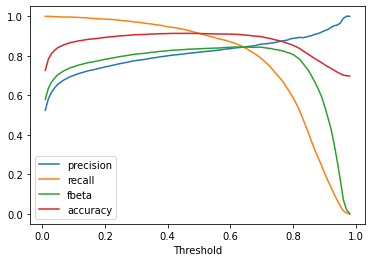

Best F-score: 0.844 | accuracy: 0.908


In [50]:
th_values = [i / 100. for i in range(1, 99)]
precision = []
recall = []
fbeta = []
accuracy = []

for th in th_values:

    batch_size = 1
    test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)

    pred = (test_pred > th).astype(int)

    if sum(pred) == 0:
        precision.append(0)
        recall.append(0)
        fbeta.append(0)
        accuracy.append(0)
    else:
        accuracy.append(metrics.accuracy_score(test_true, pred))
        precision.append(metrics.precision_score(test_true, pred))
        recall.append(metrics.recall_score(test_true, pred))
        fbeta.append(metrics.fbeta_score(test_true, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, fbeta, label="fbeta")
plt.plot(th_values, accuracy, label="accuracy")
plt.xlabel("Threshold")
plt.legend()
plt.show()

print(f"Best F-score: {max(fbeta):.3f} | accuracy: {accuracy[np.argmax(fbeta)]:.3f}")